In [2]:
pip install torch pandas scikit-learn numpy tqdm matplotlib

   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 328.9 kB/s eta 0:10:56
   ---------------------------------------- 0.5/216.1 MB 328.9 kB/s eta 0:10:56
   ---------------------------------------- 0.8/216.1 MB 396.1 kB/s eta 0:09:04
   ---------------------------------------- 0.8/216.1 MB 396.1 kB/s eta 0:09:04
   ---------------------------------------- 1.0/216.1 MB 509.2 kB/s eta 0:07:03
   ---------------------------------------- 1.3/216.1 MB 597.2 kB/s eta 0:06:00
   --------------------

Using device: cpu
Loading data...
Total samples: 16000

Label encoding:
anger: 0
fear: 1
joy: 2
love: 3
sadness: 4
surprise: 5

Building vocabulary...
Vocabulary size: 10000

Splitting data...
Train set size: 12801 (80.0%)
Val set size: 1599 (10.0%)
Test set size: 1600 (10.0%)

Model architecture:
EmotionCNN(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=6, bias=True)
)

Training the model...
Epoch [1/20]
  Train Loss: 1.6048, Train Acc: 0.3626
  Val Loss: 1.4155, Val Acc: 0.4615
  -> Saved best model
Epoch [2/20]
  Train Loss: 1.2582, Train Acc: 0.5292
  Val Loss: 1.0425, Val Acc: 0.6060
  -> Saved best model
Epoch [3/20]
  Train Loss: 0.8309, Train Acc: 0.7106
  Val Loss: 0.6348, Val Acc: 0.7749
 

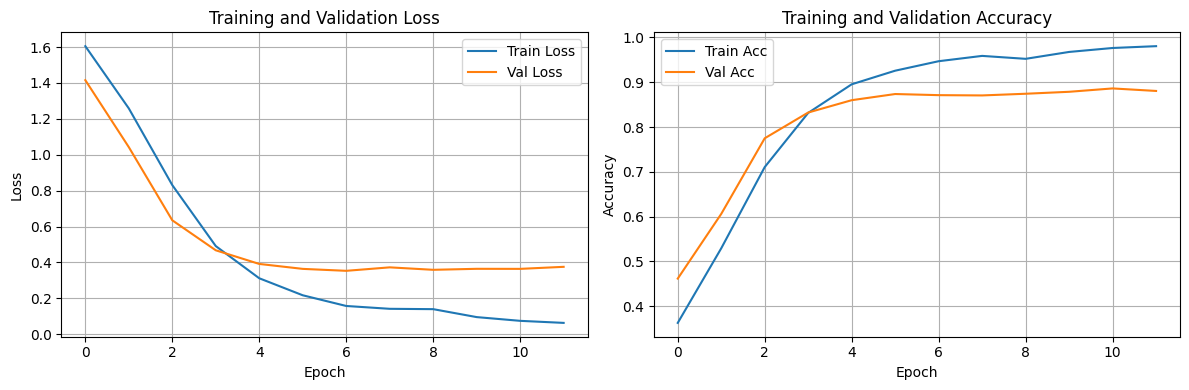

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Load and preprocess the data
print("Loading data...")
data = pd.read_csv('emotion.csv')
print(f"Total samples: {len(data)}")

# Create label encoder for emotion names
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label_name'])

# Verify label encoding
print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# 2. Text preprocessing
def preprocess_text(text):
    """Basic text preprocessing"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

data['processed_text'] = data['text'].apply(preprocess_text)

# 3. Build vocabulary
def build_vocabulary(texts, max_vocab_size=10000):
    """Build vocabulary from texts"""
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)
    
    # Keep most common words
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in word_counts.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)
    
    return vocab

print("\nBuilding vocabulary...")
vocab = build_vocabulary(data['processed_text'].values)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# 4. Convert texts to sequences
def text_to_sequence(text, vocab, max_length=100):
    """Convert text to sequence of indices"""
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]
    # Pad sequence
    if len(sequence) < max_length:
        sequence += [vocab['<PAD>']] * (max_length - len(sequence))
    return sequence

max_length = 100
sequences = np.array([text_to_sequence(text, vocab, max_length) 
                      for text in data['processed_text'].values])

# 5. Split the data
print("\nSplitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
    sequences, data['encoded_label'].values, 
    test_size=0.1, random_state=42, stratify=data['encoded_label'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.111,  # 0.111 * 0.9 ≈ 0.1 of total
    random_state=42, stratify=y_temp
)

print(f"Train set size: {len(X_train)} ({len(X_train)/len(data)*100:.1f}%)")
print(f"Val set size: {len(X_val)} ({len(X_val)/len(data)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(data)*100:.1f}%)")

# 6. Create PyTorch datasets and dataloaders
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 7. Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, 
                 filter_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super(EmotionCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(x))  # (batch_size, num_filters, conv_seq_len)
            pooled = torch.max(conv_out, dim=2)[0]  # (batch_size, num_filters)
            conv_outputs.append(pooled)
        
        # Concatenate all conv outputs
        x = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)
        
        # Dropout
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

# 8. Initialize the model
embedding_dim = 128
num_classes = len(label_encoder.classes_)
model = EmotionCNN(vocab_size, embedding_dim, num_classes).to(device)
print(f"\nModel architecture:\n{model}")

# 9. Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 10. Training loop
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (texts, labels) in enumerate(dataloader):
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), correct / total

# 11. Train the model
print("\nTraining the model...")
num_epochs = 20
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_emotion_cnn_model.pth')
        print("  -> Saved best model")
        patience_counter = 0
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# 12. Load best model and evaluate on test set
print("\nLoading best model...")
model.load_state_dict(torch.load('best_emotion_cnn_model.pth'))

# Evaluate on test set
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

print("\nEvaluating on test set...")
test_predictions, test_labels = evaluate_model(model, test_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1_macro = f1_score(test_labels, test_predictions, average='macro')
test_f1_weighted = f1_score(test_labels, test_predictions, average='weighted')

print(f"\nTest Set Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_predictions, 
                          target_names=label_encoder.classes_,
                          digits=4))

# 13. Visualize training history
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    print("\nTraining history plot saved as 'training_history.png'")
except ImportError:
    print("\nMatplotlib not available for plotting")

# 14. Example predictions
def predict_emotion(text, model, vocab, label_encoder, max_length=100):
    """Predict emotion for a single text"""
    model.eval()
    processed_text = preprocess_text(text)
    sequence = text_to_sequence(processed_text, vocab, max_length)
    input_tensor = torch.LongTensor([sequence]).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.cpu().numpy()[0]
        predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]
        
        # Get confidence scores
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        
    return predicted_emotion, probs

# Test on some example sentences
print("\nExample predictions:")
example_texts = [
    "I am so happy today!",
    "This is really frustrating and annoying.",
    "I'm scared about what might happen.",
    "I love spending time with my family.",
    "Everything feels hopeless and sad.",
    "Wow, I didn't expect that at all!"
]

for text in example_texts:
    emotion, probs = predict_emotion(text, model, vocab, label_encoder)
    print(f"\nText: '{text}'")
    print(f"Predicted emotion: {emotion}")
    print("Confidence scores:")
    for i, prob in enumerate(probs):
        emotion_name = label_encoder.inverse_transform([i])[0]
        print(f"  {emotion_name}: {prob:.4f}")